In [1]:
# Import necessary packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torchshow as ts
import pickle

torch.Size([8, 4, 69, 600])


/Users/luca/Desktop/ML/SignalReconstructionML/.venv/lib/python3.10/site-packages/torchshow/visualization.py:378: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


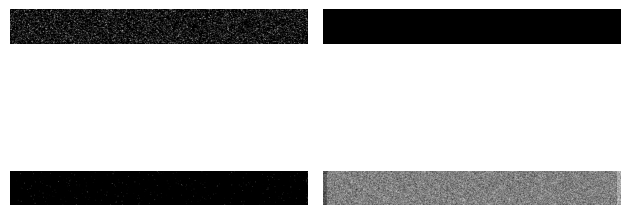

In [2]:
# Dense Block
class DenseBlock(nn.Module):
    def __init__(self, in_channels):
        super(DenseBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels+8, 8, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels+2*8, 8, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels+3*8, 8, kernel_size=3, padding=1)

    def forward(self, x):
            x1 = F.relu(self.conv1(x))
            x2 = F.relu(self.conv2(torch.cat([x, x1], dim=1)))
            x3 = F.relu(self.conv3(torch.cat([x, x1, x2], dim=1)))
            x4 = F.relu(self.conv4(torch.cat([x, x1, x2, x3], dim=1)))
            out = torch.cat([x, x1, x2, x3, x4], dim=1)
            return out
    
# Transition Down
class TransitionDown(nn.Module):
    def __init__(self, in_channels, stride):
        super(TransitionDown, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.avg_pool = nn.AvgPool2d(kernel_size=(2, 1), stride=(stride, 1),ceil_mode=True)

    def forward(self, x):
        x = F.relu(self.conv(x))
        out = self.avg_pool(x)
        return out
    
# Transition Expand
class TransitionExpand(nn.Module):
    def __init__(self, in_channels, out_channels=16, stride=1):
        super(TransitionExpand, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.avg_pool = nn.AvgPool2d(kernel_size=(2, 1), stride=(stride, 1),ceil_mode=True)

    def forward(self, x):
        x = F.relu(self.conv(x))
        out = self.avg_pool(x)
        return out

tensor = torch.randn(size=(8, 2, 513, 600))  # Example batch of size 8
tdown = TransitionExpand(in_channels=2, stride=2)
out = tdown(tensor)

# Transition Up
class TransitionUp(nn.Module):
    def __init__(self, in_channels, out_channels=16, stride=1):
        super(TransitionUp, self).__init__()
        self.transconv = nn.ConvTranspose2d(in_channels=in_channels,
                                            out_channels=out_channels,
                                            kernel_size=(3, 1),
                                            stride=(stride, 1),
                                            padding=(1, 0),
                                            output_padding=0)

    def forward(self, x):
        out = F.relu(self.transconv(x))
        return out
    

# Transition Final
class TransitionFinal(nn.Module):
    def __init__(self, in_channels):
        super(TransitionFinal, self).__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=1)

    def forward(self, x):
        out = self.conv(x)
        return out  # out.squeeze(1) would remove the singleton channel dimension
    

# Linear Compressor
class LinearCompressor(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearCompressor, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.1)
        
    def forward(self, x):
        # Get the original shape
        orig_shape = x.shape
        
        # Reshape the tensor to be [batch_size, channel * 600, 69]
        x = x.view(orig_shape[0], -1, self.linear.in_features)
        
        # Apply the linear layer
        x = self.linear(x)
        
        # Apply the LeakyReLU activation
        x = self.leaky_relu(x)
        
        # Reshape the tensor back to the original shape but with the second dimension replaced
        x = x.view(orig_shape[0], orig_shape[1], self.linear.out_features, -1)
        
        return x



# Temporal Block
class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TemporalBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 3), padding=(0, 1), dilation=(1, 1))
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 3), padding=(0, 2), dilation=(1, 2))
        self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 3), padding=(0, 4), dilation=(1, 4))
        self.conv4 = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 3), padding=(0, 8), dilation=(1, 8))

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out1 = self.relu(self.conv1(x))
        out2 = self.relu(self.conv2(x))
        out3 = self.relu(self.conv3(x))
        out4 = self.relu(self.conv4(x))

        out = torch.cat((out1, out2, out3, out4), dim=1)  # Concatenate along the channel axis

        return out
    
x = torch.rand(8,1, 69, 600) 
tb = TemporalBlock(1,1)

x = tb(x)
print(x.shape)

ts.show(x[0])


In [3]:
# Alpha Model

class VariationalAutoencoder(nn.Module):
    def __init__(self):
        # Encoder Blocks
        super(VariationalAutoencoder, self).__init__()
        self.block2 = DenseBlock(in_channels=2)
        self.block34 = DenseBlock(in_channels=34)
        self.block100 = DenseBlock(in_channels=100)
        self.block232 = DenseBlock(in_channels=232)

        self.transdown34_2 = TransitionDown(in_channels=34,stride=2)
        self.transdown34_4 = TransitionDown(in_channels=34,stride=4)
        self.transdown34_8 = TransitionDown(in_channels=34,stride=8)
        self.transdown66_2 = TransitionDown(in_channels=66,stride=2)
        self.transdown66_4 = TransitionDown(in_channels=66,stride=4)
        self.transdown132_2 = TransitionDown(in_channels=132,stride=2)

        self.transfinal = TransitionFinal(in_channels=264)


        self.linearCompressor = LinearCompressor(65,32)

        # Decoder Blocks
        ## Linear Block
        self.linearCompressorUp = LinearCompressor(32,65)

        ## Transition Up Blocks
        self.transup_4_8 = TransitionUp(4,16,8)
        self.transup_4_2 = TransitionUp(4,16,2)
        self.transup_4_4 = TransitionUp(4,16,4)
        self.transup_48_2 = TransitionUp(48,16,2)
        self.transup_48_4 = TransitionUp(48,16,4)
        self.transup_64_2 = TransitionUp(64,16,2)

        ## Dense Blocks
        self.block16 = DenseBlock(16)
        self.block32 = DenseBlock(32)
        self.block48 = DenseBlock(48)

        ## Transiton Final Blocks
        self.transfinal2 = TransitionFinal(in_channels=80)

        ## Temporal Block
        self.tempBlock = TemporalBlock(1,1)

    def encoder(self,x):
        x = self.block2(x)

        x1 = self.transdown34_8(x)
        x2 = self.transdown34_4(x) # required in cat
        x3 = self.transdown34_2(x)

        x3 = self.block34(x3)
        x3 = self.transdown66_2(x3)
        x4 = self.transdown66_2(x3)

        x2 = torch.cat([x2,x3],dim=1)
        x2 = self.block100(x2)
        x2 = self.transdown132_2(x2)

        x = torch.cat([x1,x2,x4],dim=1)

        mu = self.linearCompressor(self.transfinal(self.block232(x)))
        sigma = self.linearCompressor(self.transfinal(self.block232(x)))

        return mu, sigma

        
    def magnitude_decoder(self,z):
        z = self.tempBlock(z) # Temp Block
        z = self.linearCompressorUp(z) # Linear Layer

        z1 = self.transup_4_8(z)
        z2 = self.transup_4_4(z)
        z3 = self.transup_4_2(z)

        z3 = self.block16(z3)
        z3s = z3.clone()


        z3 = self.transup_48_2(z3)

        z2 = torch.cat([z2,z3],dim=1)
        z2 = self.block32(z2)
        z2 = self.transup_64_2(z2)
        z4 = self.transup_48_4(z3s)

        z1 = torch.cat([z1,z2,z4],dim=1)
        z2 = z1.clone()

        z1 = self.block48(z1)
        z2 = self.block48(z2)

        z1 = self.transfinal2(z1)
        z2 = self.transfinal2(z2)

        return z1, z2

    def phase_decoder(self,z,est_mag,est_var):
        pass

    def forward(self,x):
        mu, sigma = self.encoder(x)
        epsilon = torch.randn_like(sigma)
        z_reparametrised = mu + sigma*epsilon
        var, x_reconstructed = self.magnitude_decoder(z_reparametrised)

        return x_reconstructed, mu, sigma

In [4]:
model = VariationalAutoencoder()
# t = torch.randn(1,2,517,600)

# mu, sigma = model.encoder(t)
# epsilon = torch.randn_like(sigma)
# z = mu + mu + epsilon

# x,z = model.magnitude_decoder(z)

# ts.set_color_mode('rgb')
# ts.show(z)

In [5]:
# Dataloader & Device
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
INPUT_DIM = 784
H_DIM = 200
Z_DIM = 20
NUM_EPOCHS = 1
BATCH_SIZE = 32
LR_RATE = 3e-5 # kaparthy constant

model = model.to(device)
optimiser = optim.Adam(model.parameters(),lr=LR_RATE)
loss_fn = nn.BCELoss(reduction="sum")

with open('../data/ProcessedAudioMNIST/DataLoader.pkl', 'rb') as file:
    DataLoader = pickle.load(file)

7it [02:46, 23.79s/it, loss=-1.57e+8]


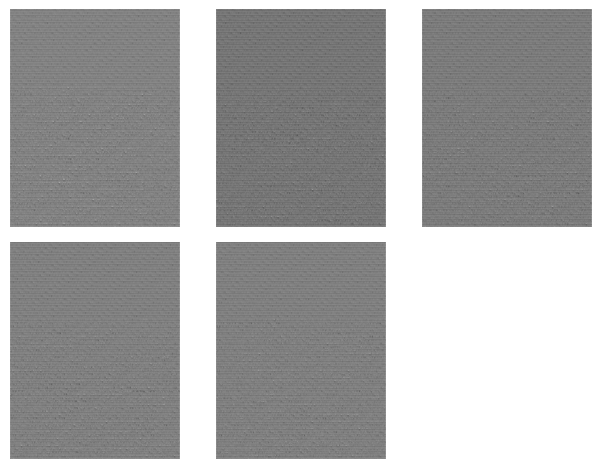

In [6]:
# Training Loop

for epoch in range(NUM_EPOCHS):
    loop = tqdm(enumerate(DataLoader))
    for i, x in loop:
        # Forward pass
        x = x[0].to(device)

        x_reconstructed, mu, sigma = model(x)

        mag = x.clone()[:, 0:1, :, :]

        # Compute Loss
        reconstruction_loss = loss_fn(x_reconstructed,mag)
        kl_div = -torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2)-sigma.pow(2))

        # backprop
        loss = reconstruction_loss + kl_div
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        loop.set_postfix(loss=loss.item())
    ts.show(x_reconstructed)
        

In [7]:
total_params = sum(p.numel() for p in model.parameters())
print("Total number of parameters: ", total_params)



Total number of parameters:  200541


In [20]:
lin = LinearCompressor(32,69)
t = torch.randn(size=(8,4,32,200))

lin(t).shape

torch.Size([8, 4, 69, 200])

In [7]:
x_reconstructed.shape

torch.Size([5, 1, 513, 400])

In [8]:
import matplotlib.pyplot as plt
import torch

x_reconstructed = x_reconstructed.detach()
# Assuming your tensor is named 'tensor'
# # Convert the torch tensor to a NumPy array
# array = x_reconstructed.squeeze().permute(1, 2, 0).numpy()

# Display the array using matplotlib
# plt.imshow(array)
# plt.show()


In [9]:
x_reconstructed = x_reconstructed.squeeze()

In [10]:
x_reconstructed = x_reconstructed[0]


In [11]:
array = x_reconstructed.cpu().numpy()

(513, 400, 5)

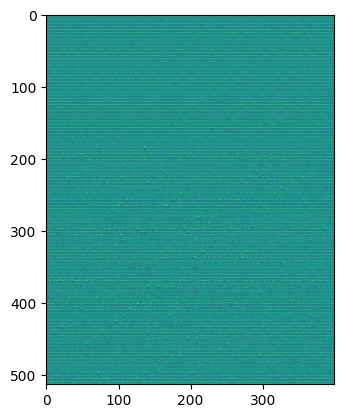

In [12]:
plt.imshow(array)
plt.show()